In [1]:
import os                                               #os interface library 
import requests                                         #HTTP requests library
import pandas as pd                                     #panda library
from dotenv import load_dotenv                          #dotenv library to read keys and secrect key for api
import alpaca_trade_api as trade_api                    #Alpaca library
from alpaca_trade_api.rest import REST, TimeFrame
from MCForecastTools import MCSimulation                #Monta Carlos simulation apis
import json                                             #JSON library ro work with JSON objects
from datetime import date                               #Data-Time library
import yfinance as yf
#set the backend of matplotlib to the 'inline' backend 
%matplotlib inline 
# Load .env enviroment variables
import numpy as np
def setting_api():
    alpaca_api_key=os.getenv("ALPACA_API_KEY")
    alpaca_secret_key=os.getenv("ALPACA_SECRET_KEY")
    alpaca = trade_api.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')
    return alpaca
    

In [2]:
load_dotenv()

True

In [3]:
# # Function for retrieving data relative to tickers/portfolio
def portfolio_data(tickers):
    today = date.today() + pd.DateOffset(years=-5)                        
    today = pd.Timestamp(today, tz="America/New_York").isoformat()  
    timeframe ='1Day'
    portfolio =alpaca.get_bars(tickers,timeframe,start=today,adjustment='raw').df
    portfolio.index = portfolio.index.date
    return portfolio
# function for retrieving data related to benchmark:
def bench_mark(symbol):
    bench_mark = portfolio_data(symbol)
    symbol = bench_mark[['close']].rename(columns ={'close': symbol})
    return symbol
def riskf_r():
    today = date.today() + pd.DateOffset(years=-5)
    rf_rate = yf.download('^IRX',start = today)
    rf_rate = rf_rate[['Close']]
    rf_rate = rf_rate.rename(columns = {'Close' : 'rf_rate'})
    rf_returns = rf_rate.pct_change()
    rf_returns = rf_returns.dropna()
    return rf_returns
                
    
# function to seperate the required data :
def format_data(symbol):
    ticker =portfolio[portfolio["symbol"]==symbol].drop("symbol", axis=1)
    closing_price = ticker[['close']]
    closing_price = closing_price.rename(columns={'close' : 'close'})
    return closing_price
# function for calculating cuumulative returns:
def cumulative_returns(data):
    data_returns = data.pct_change()
    data_cumulative = (1+data_returns).cumprod()
    return data_cumulative
# function for equally weghting stocks:
def equal_weights(data):
    weights = []
    for i in range(0,len(portfolio.columns)):
        w = 1/len(portfolio.columns)
        weights.append(w)
    return weights   
# function for varrying weights:
def combination_weights(data,initial_investment):
    from itertools import combinations
    import numpy as np
    df = []
    a = list(np.arange(0.05,1,0.01))
    random_set = [round(i,3) for i in a]
    
    comb = combinations(random_set,len(data.columns))
    possible_combinations = []
    # for loop for appropriate weights :
    for i in comb:
        if sum(i) == 1:
            possible_combinations.append(i)
    daily_returns = data.pct_change().dropna()
    for i in possible_combinations:
        possible_returns = daily_returns.dot(i)
        cumulative_final_return = (1+possible_returns).cumprod()
        final_day_value = cumulative_final_return.iloc[-1]
        final_return = final_day_value*initial_investment
        df.append((final_return,i))
    data_frame = pd.DataFrame(df)
    best_combination = data_frame.rename(columns={0:'Return',1:'Weights'})
    top_5 = best_combination.nlargest(5,'Return')
    
    return top_5
# function for sharpe ratios :
def sharpe_ratios(a):
    best_weights = a['Weights']
    cumulative_weighted_portfolios = []
    for i in best_weights:
        weighted_price_action = portfolio_cumulative.dot(i)
        cumulative_weighted_portfolios.append(weighted_price_action)
        c_w_p = pd.DataFrame(cumulative_weighted_portfolios)
    c_w_p = c_w_p.T
    c_w_p = c_w_p.rename(columns ={0 :'w1',1:'w2',2:'w3',3:'w4',4:'w5'})
    c_w_returns = c_w_p.pct_change()
    c_w_r =c_w_returns.dropna()
    assembled_returns = pd.concat([c_w_r,r_rate],axis =1 ,join ='inner')
    s_r = ((assembled_returns.mean()-assembled_returns['rf_rate'].mean())*252)/(assembled_returns.std()*np.sqrt(252))
    sharpe_ratio = pd.Series(s_r)
    sharpe_ratio = sharpe_ratio.drop('rf_rate')
    a['sharpe_ratio'] = sharpe_ratio.values
    return a
def benchmark_comaprison(b):
    spy_returns = spy.pct_change()
    spy_returns = spy_returns.dropna()
    spy_final_value = spy_cumulative*1000
    spy_final_value=list(spy_final_value.iloc[-1])
    spy_sharpe = pd.concat([spy_returns,r_rate],axis = 1,join ='inner')
    spy_sharpe_ratio = ((spy_sharpe.mean()-spy_sharpe['rf_rate'].mean()))*252/(spy_sharpe.std()*np.sqrt(252))
    spy_sharpe_ratio =pd.Series(spy_sharpe_ratio)
    spy_sharpe_ratio = spy_sharpe_ratio['SPY']
    sharpe_ratio.loc['SPY'] = [spy_final_value[0],((1)),spy_sharpe_ratio]
    percent_return = []
    for i in sharpe_ratio['Return']:
        initial_investment = 1000
        per_return = ((i - initial_investment)/i)*100
        percent_return.append(per_return)
    sharpe_ratio['%_return'] = percent_return
    return sharpe_ratio



In [4]:
alpaca = setting_api()
tickers = ['APD', 'FLEX', 'PPG', 'TEL', 'IFF', 'GLW']
portfolio = portfolio_data(tickers)
portfolio.head()


,open,high,low,close,volume,trade_count,vwap,symbol
2017-04-18,135.04,136.0200,134.72,135.27,701020,10116,135.259170,APD
2017-04-19,135.73,136.0399,134.78,134.96,577819,7170,135.166924,APD
2017-04-20,135.62,137.3400,135.20,136.90,985329,10779,136.676759,APD
2017-04-21,136.87,137.6600,136.82,137.30,1121329,9645,137.275887,APD
2017-04-24,138.79,139.9000,137.91,139.76,1006799,11797,139.453526,APD


In [5]:
apd =format_data('APD')
flx =format_data('FLEX')
ppg=format_data('PPG')
tel=format_data('TEL')
iff=format_data('IFF')
glw=format_data('GLW')
apd.head()

,close
2017-04-18,135.27
2017-04-19,134.96
2017-04-20,136.90
2017-04-21,137.30
2017-04-24,139.76


In [6]:
portfolio = pd.concat([apd,flx,ppg,tel,iff,glw],axis =1,keys = ['APD','FLEX','PPG','TEL','IFF','GLW'])
portfolio.head()

,APD,FLEX,PPG,TEL,IFF,GLW
,close,close,close,close,close,close
2017-04-18,135.27,15.96,104.74,73.08,134.07,26.89
2017-04-19,134.96,16.00,105.00,73.18,134.53,26.86
2017-04-20,136.90,15.97,106.37,74.12,135.80,27.11
2017-04-21,137.30,15.97,105.94,73.61,136.12,27.02
2017-04-24,139.76,16.10,108.01,75.21,138.03,27.52


In [7]:
spy = bench_mark('SPY')

In [8]:
r_rate = riskf_r()

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:>

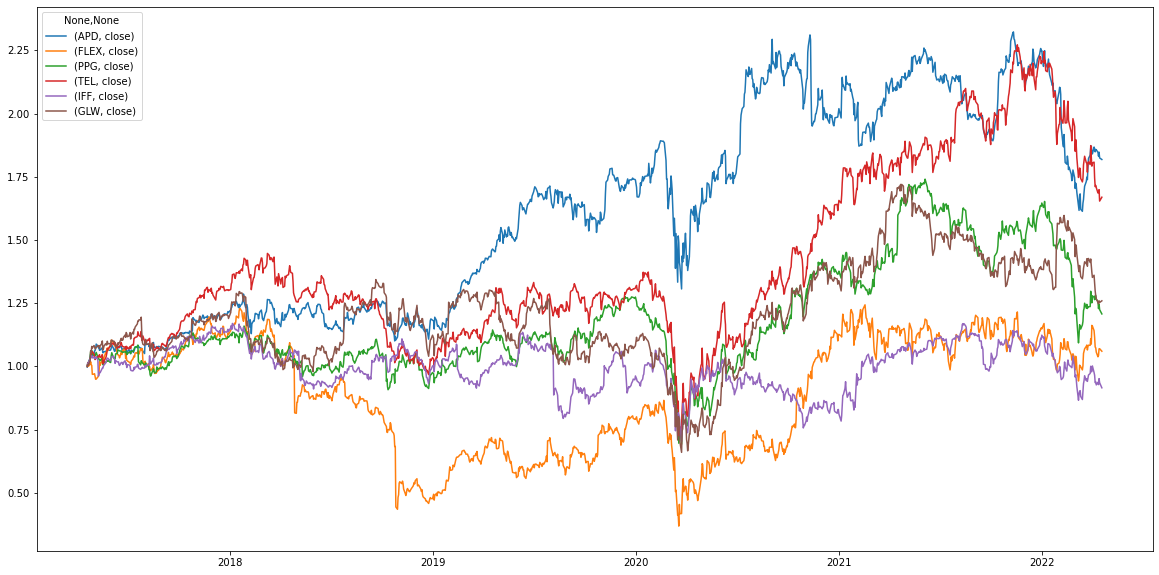

In [9]:
spy_cumulative = cumulative_returns(spy)
portfolio_cumulative = cumulative_returns(portfolio)
portfolio_cumulative.plot(figsize = (20,10))

<AxesSubplot:>

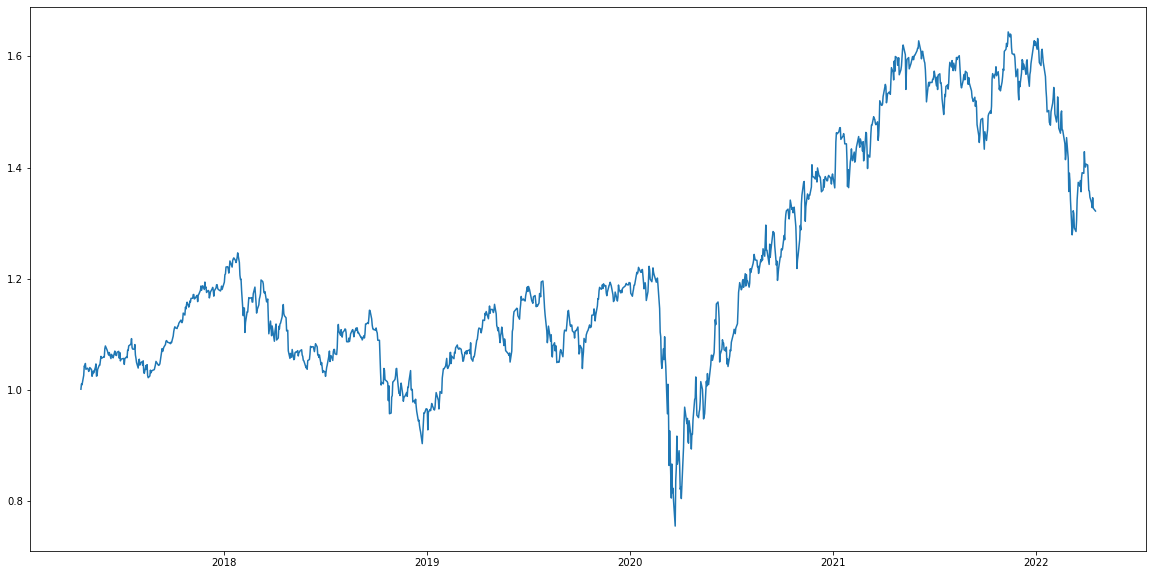

In [10]:
weights = equal_weights(portfolio)
portfolio_price_action = portfolio_cumulative.dot(weights)
portfolio_price_action.plot(figsize = (20,10))

In [11]:
#Concat the df and clean the data as well
comparison = pd.concat([portfolio_price_action,spy_cumulative],axis = 1 ,join = 'inner').dropna()
comparison = comparison.rename(columns = {0:'E.W Portfolio'})

<AxesSubplot:>

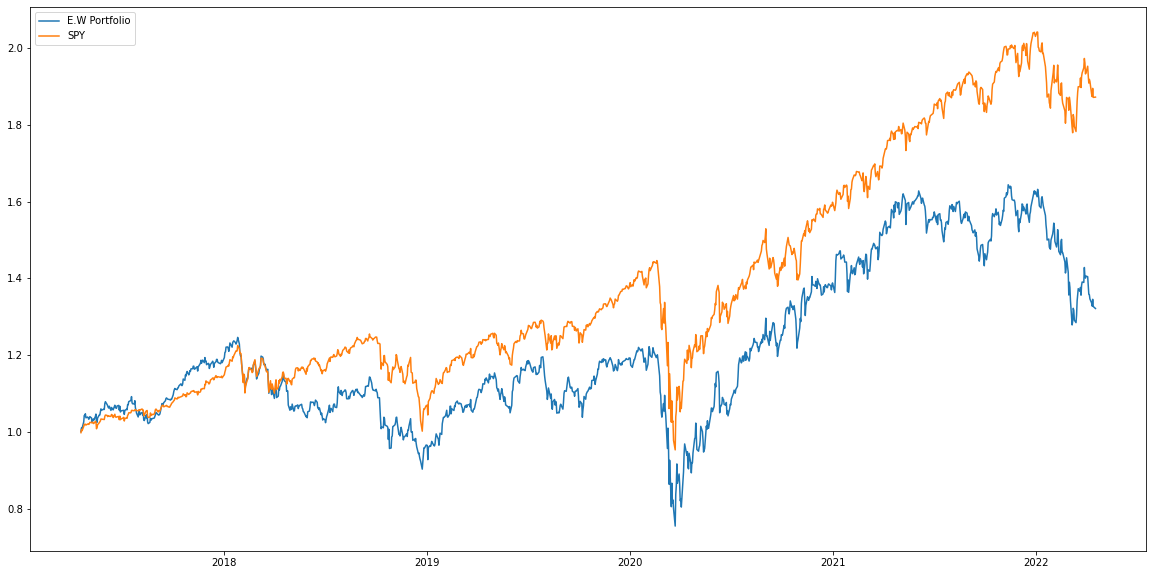

In [12]:
#Plot the comparison data
comparison.plot(figsize = (20,10))

In [13]:
#run Monte Carlos simulation 
sim_ew = MCSimulation(
    portfolio,
    weights=equal_weights(portfolio),
    num_simulation=1000,
    num_trading_days=252,
)

In [14]:
sim_ew.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\Zahra\Desktop\Responsible_Investor\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.991270,0.992371,1.000249,0.989282,0.989992,0.995703,1.002883,1.001223,1.003584,1.002190,...,1.005414,1.001546,0.987761,0.989364,0.997827,1.011369,0.997896,1.012764,0.992510,0.999780
2,0.975876,0.990958,0.997004,0.993942,0.981242,0.997509,1.012494,1.015239,1.004472,0.995493,...,1.003652,0.997580,1.004406,0.991812,1.010843,1.006768,1.007605,1.016894,0.996996,0.992038
3,0.972967,0.988638,0.999749,0.995113,0.986029,0.992058,1.020763,1.019671,1.002401,0.990454,...,0.991551,1.002238,1.003993,0.992769,1.021017,0.999632,1.022345,1.011646,0.998644,0.993980
4,0.972847,0.985014,1.001577,0.998993,0.972254,0.995440,1.031451,1.025574,1.005178,0.997856,...,0.998346,1.006484,0.998961,1.003273,1.007745,0.986609,1.019767,1.016037,1.004564,1.004121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0.966442,1.089381,1.046836,1.130231,0.999653,1.161922,1.078257,1.186986,1.269251,0.904714,...,1.082780,1.420230,1.430347,1.063059,1.102557,1.104054,0.905603,1.488046,1.232025,1.233971
249,0.955263,1.082784,1.054215,1.128003,1.003041,1.148461,1.090996,1.189939,1.282824,0.904592,...,1.067654,1.414444,1.423400,1.055921,1.109108,1.106881,0.905936,1.498843,1.210597,1.225541
250,0.953835,1.076054,1.050682,1.132668,1.000720,1.150912,1.090442,1.185118,1.271710,0.908966,...,1.062830,1.411556,1.426035,1.063084,1.116808,1.110232,0.890011,1.504175,1.199674,1.229653
251,0.936712,1.085319,1.037067,1.135018,0.998778,1.145521,1.084023,1.174368,1.274082,0.897135,...,1.075433,1.412108,1.420871,1.067103,1.124596,1.112980,0.898563,1.514178,1.200861,1.224920


<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days.'}>

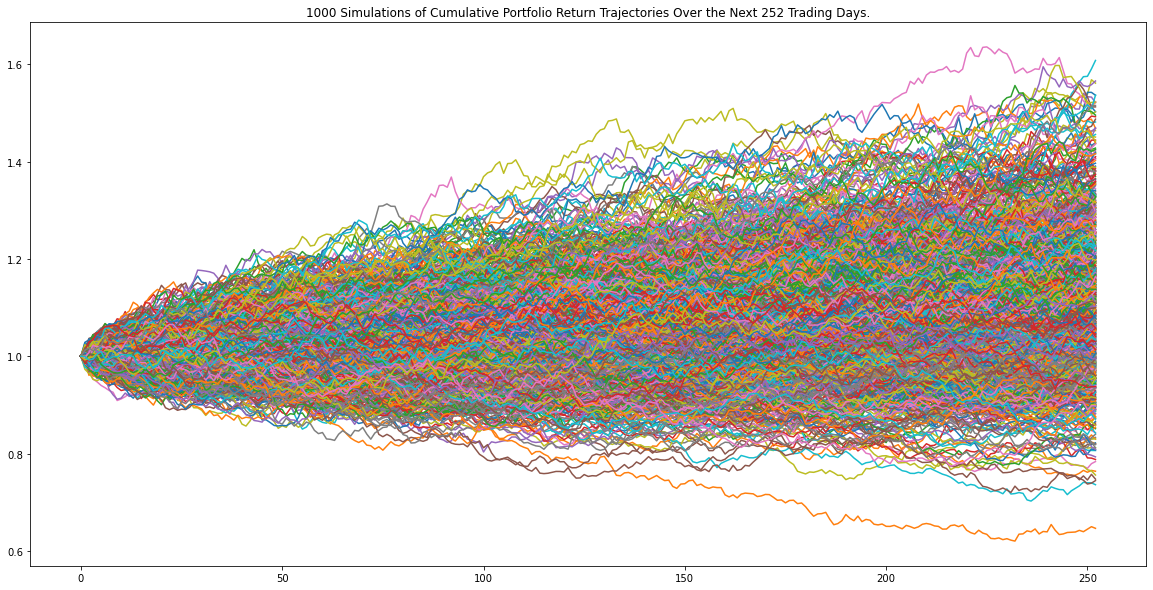

In [15]:
sim_ew.plot_simulation()

In [16]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_stats = sim_ew.summarize_cumulative_return()

# Print summary statistics
print(summary_stats)

# Set initial investment
initial_investment = 20000

# Using lower & upper CI to calculate the `95%` confidence intervalsfor investment of $20,000
ci_lower = round(summary_stats[8] * initial_investment, 2)
ci_upper = round(summary_stats[9] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment:,.02f} in the portfolio"
      f" over a year will end within in the range of"
      f" ${ci_lower:,.02f} and ${ci_upper:,.02f}")

count           1000.000000
mean               1.116131
std                0.148702
min                0.646560
25%                1.006924
50%                1.109892
75%                1.207256
max                1.607656
95% CI Lower       0.854007
95% CI Upper       1.438499
Name: 252, dtype: float64
There is a 95% chance that an initial investment of $20,000.00 in the portfolio over a year will end within in the range of $17,080.15 and $28,769.97


In [17]:
top_returns = combination_weights(portfolio,initial_investment=1000)

In [18]:
top_returns

,Return,Weights
13442,1419.258274,"(0.14, 0.15, 0.16, 0.17, 0.18, 0.2)"
13429,1414.640201,"(0.13, 0.14, 0.15, 0.16, 0.17, 0.25)"
13433,1414.516579,"(0.13, 0.14, 0.15, 0.17, 0.18, 0.23)"
13436,1414.214804,"(0.13, 0.14, 0.15, 0.18, 0.19, 0.21)"
13440,1413.985420,"(0.13, 0.15, 0.16, 0.17, 0.18, 0.21)"


In [19]:
sharpe_ratio = sharpe_ratios(top_returns)

C:\Users\Zahra\anaconda3\envs\alpacaenv\lib\site-packages\pandas\core\indexes\base.py:334: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  joined_ndarray, lidx, ridx = libjoin.inner_join_indexer(sv, ov)
C:\Users\Zahra\anaconda3\envs\alpacaenv\lib\site-packages\pandas\core\dtypes\missing.py:484: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ensure_object(left.ravel()), ensure_object(right.ravel())


In [20]:
sharpe_ratio

,Return,Weights,sharpe_ratio
13442,1419.258274,"(0.14, 0.15, 0.16, 0.17, 0.18, 0.2)",-2.696971
13429,1414.640201,"(0.13, 0.14, 0.15, 0.16, 0.17, 0.25)",-2.672069
13433,1414.516579,"(0.13, 0.14, 0.15, 0.17, 0.18, 0.23)",-2.683456
13436,1414.214804,"(0.13, 0.14, 0.15, 0.18, 0.19, 0.21)",-2.693799
13440,1413.985420,"(0.13, 0.15, 0.16, 0.17, 0.18, 0.21)",-2.689890


In [21]:
# def benchmark_comaprison(b):
#     spy_returns = spy.pct_change()
#     spy_returns = spy_returns.dropna()
#     spy_final_value = spy_cumulative*1000
#     spy_final_value=list(spy_final_value.iloc[-1])
#     spy_sharpe = pd.concat([spy_returns,r_rate],axis = 1,join ='inner')
#     spy_sharpe_ratio = ((spy_sharpe.mean()-spy_sharpe['rf_rate'].mean()))*252/(spy_sharpe.std()*np.sqrt(252))
#     spy_sharpe_ratio =pd.Series(spy_sharpe_ratio)
#     spy_sharpe_ratio = spy_sharpe_ratio['SPY']
#     sharpe_ratio.loc['SPY'] = [spy_final_value[0],((1)),spy_sharpe_ratio]
#     percent_return = []
#     for i in sharpe_ratio['Return']:
#         initial_investment = 1000
#         per_return = ((i - initial_investment)/i)*100
#         percent_return.append(per_return)
#     sharpe_ratio['%_return'] = percent_return
#     return sharpe_ratio
    
    
    

In [22]:
benchmark_comaprison(sharpe_ratio)

,Return,Weights,sharpe_ratio,%_return
13442,1419.258274,"(0.14, 0.15, 0.16, 0.17, 0.18, 0.2)",-2.696971,29.540661
13429,1414.640201,"(0.13, 0.14, 0.15, 0.16, 0.17, 0.25)",-2.672069,29.310647
13433,1414.516579,"(0.13, 0.14, 0.15, 0.17, 0.18, 0.23)",-2.683456,29.304469
13436,1414.214804,"(0.13, 0.14, 0.15, 0.18, 0.19, 0.21)",-2.693799,29.289384
13440,1413.985420,"(0.13, 0.15, 0.16, 0.17, 0.18, 0.21)",-2.689890,29.277913
SPY,1872.707059,1.0,-3.029788,46.601365
